This notebook is used for documenting my improvements to the shadow mask generation

Zhu & Woodcock suggest the following test to identify pixels that are likely to contain water:

(NDVI < 0.01 && B04_landsat < 0.11) || (NDVI < 0.1 && B04_landsat < 0.05)

In sentinel 2, B08 is about the same as B04 landsat.

In addition, I remove any pixels that we identified as cloud pixels in the previous step.

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import rasterio
from pathlib import Path

mpl.rcParams['figure.dpi'] = 200

In [67]:
base_path = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570/2019-05-22/testing_shadow_detection")

rgb = rasterio.open(base_path.parent.joinpath("RGB.tif")).read()
rgb_image = np.transpose(rgb, (1, 2, 0))

norm = colors.Normalize(vmin=rgb_image.min(), vmax=rgb_image.max())
rgb_image = norm(rgb_image)

water_test = rasterio.open(base_path.joinpath("water_test.tif")).read(1)

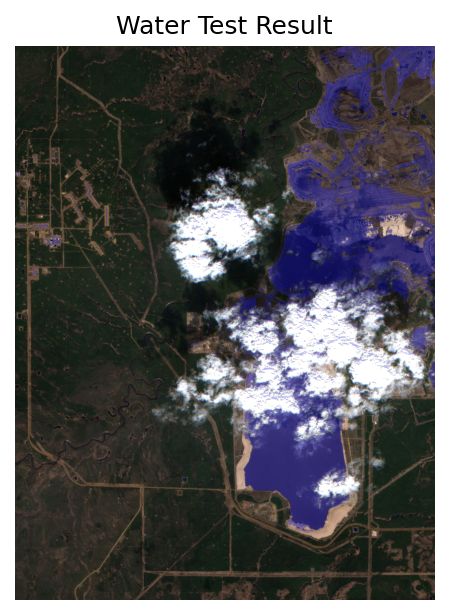

In [27]:
plt.imshow(rgb_image)
plt.axis("off")
plt.title("Water Test Result")
mask_image = np.zeros((*water_test.shape, 4))
mask_image[..., 2] = water_test
mask_image[..., 3] = water_test * 0.3
plt.imshow(mask_image)

plt.savefig("water_test.png", dpi=300, bbox_inches="tight")

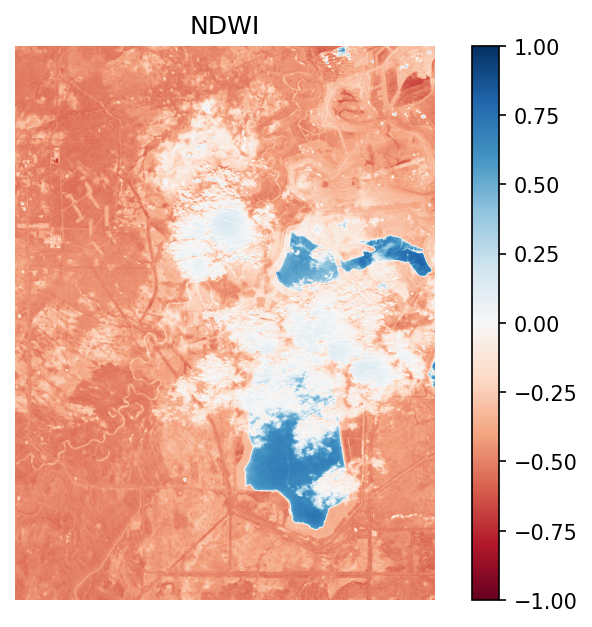

In [37]:
ndwi = rasterio.open(base_path.parent.joinpath("mNDWI.tif")).read(1)
ndmi = rasterio.open(base_path.parent.joinpath("NDMI.tif")).read(1)

plt.imshow(ndwi, vmin=-1.0, vmax=1.0, cmap="RdBu")
plt.title("NDWI")
plt.colorbar()
plt.axis("off")

plt.savefig("ndwi.png", dpi=300, bbox_inches="tight")

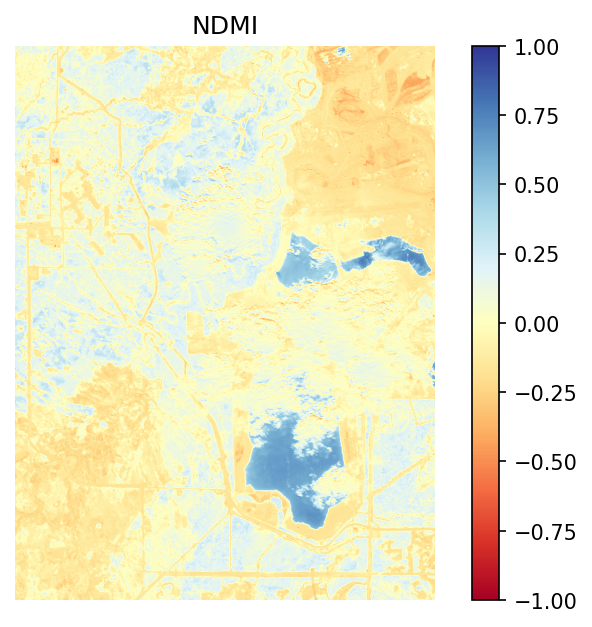

In [44]:
plt.imshow(ndmi, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
plt.title("NDMI")
plt.colorbar()
plt.axis("off")

plt.savefig("ndmi.png", dpi=300, bbox_inches="tight")

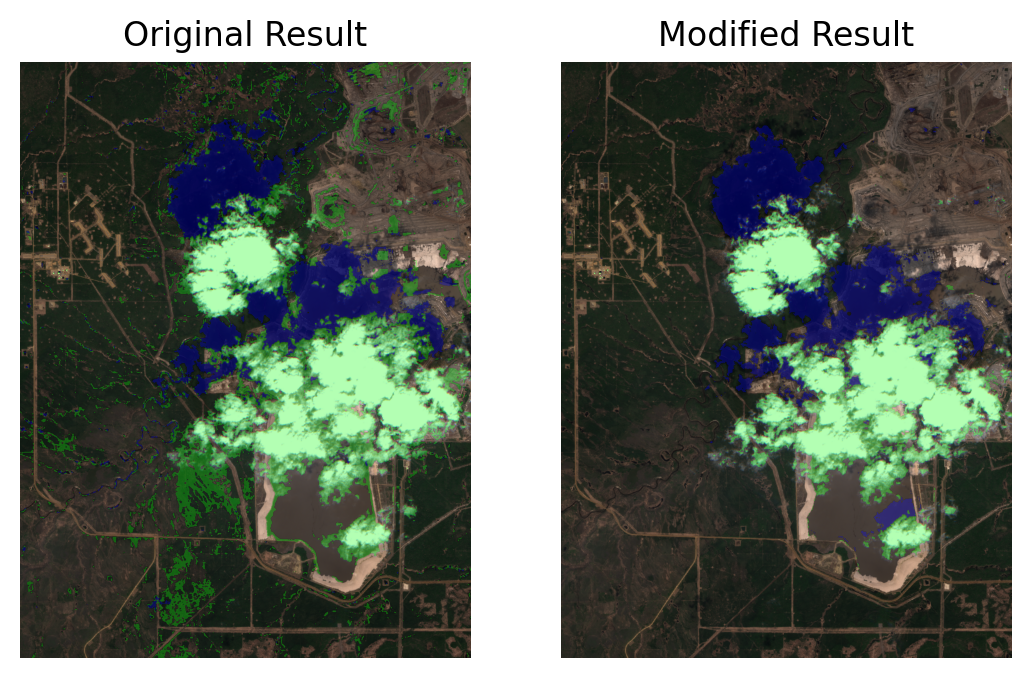

In [98]:
base_path = Path("/home/ebiederstadt/masters/Cloud-Shadow-Detection/output")
clouds = rasterio.open(base_path.joinpath("cloud_mask.tif")).read(1)
shadows = rasterio.open(base_path.joinpath("fsm.tif")).read(1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(rgb_image)
ax[0].axis("off")
mask_image = np.zeros((*shadows.shape, 4))
mask_image[..., 1] = clouds
mask_image[..., 2] = shadows
mask_image[..., 3] = np.bitwise_or(shadows, clouds) * 0.3
ax[0].imshow(mask_image)
ax[0].set_title("Original Result")

base_path = Path("/home/ebiederstadt/Documents/sentinel_cache/bbox-111.9314176_56.921209032_-111.6817217_57.105787570/2019-05-22")
new_clouds = rasterio.open(base_path.joinpath("cloud_mask.tif")).read(1)
new_shadows = rasterio.open(base_path.joinpath("shadow_mask.tif")).read(1)

ax[1].imshow(rgb_image)
mask_image = np.zeros((*shadows.shape, 4))
mask_image[..., 1] = new_clouds
mask_image[..., 2] = new_shadows
mask_image[..., 3] = np.bitwise_or(new_shadows, new_clouds) * 0.3
ax[1].imshow(mask_image)
ax[1].set_title("Modified Result")
ax[1].axis("off")

plt.show()

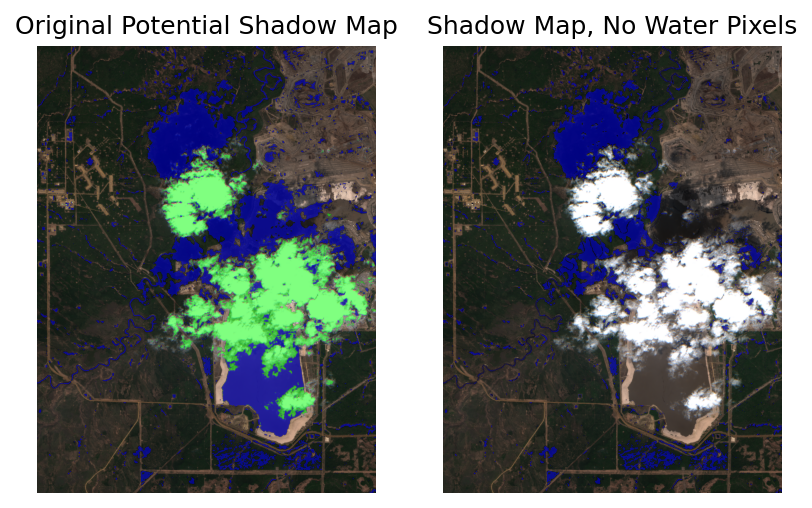

In [39]:
# Try taking the potential shadow mask, excluding any pixels that are identified as water through the different bands that we have

shadows = rasterio.open(base_path.joinpath("potential_shadows.tif")).read(1)
clouds = rasterio.open(base_path.joinpath("cloud_mask_simple.tif")).read(1)

shadow_no_water = np.bitwise_and(shadows, np.bitwise_not(water_test))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(rgb_image)
ax[0].axis("off")
ax[0].set_title("Original Potential Shadow Map")
mask_image = np.zeros((*shadows.shape, 4))
mask_image[..., 1] = clouds
mask_image[..., 2] = shadows
mask_image[..., 3] = np.bitwise_or(shadows, clouds) * 0.5
ax[0].imshow(mask_image)

ax[1].imshow(rgb_image)
mask_image = np.zeros((*shadows.shape, 4))
mask_image[..., 2] = shadow_no_water
mask_image[..., 3] = shadow_no_water * 0.5
ax[1].imshow(mask_image)
ax[1].axis("off")
ax[1].set_title("Shadow Map, No Water Pixels")

plt.savefig("shadow_masks.png", dpi=300, bbox_inches="tight")

(-0.5, 1283.5, 1696.5, -0.5)

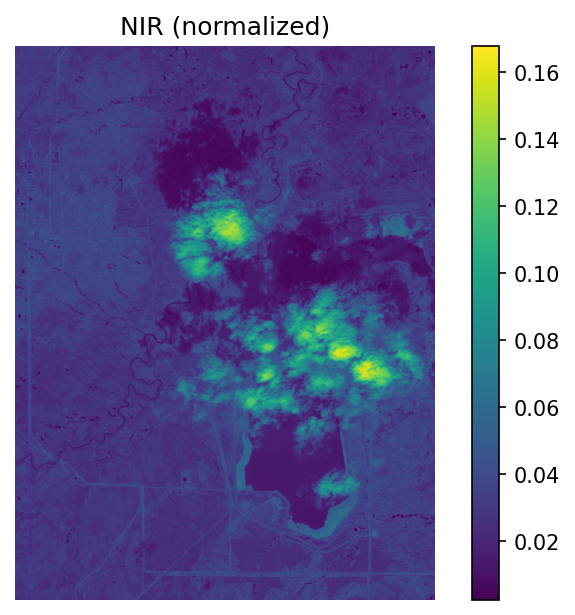

In [31]:
# NIR

max = 65535
nir = rasterio.open(base_path.parent.joinpath("B08.tif")).read(1)
nir = nir / max

plt.imshow(nir)
plt.colorbar()
plt.title("NIR (normalized)")
plt.axis("off")

Text(0.5, 1.0, 'SWIR (normalized)')

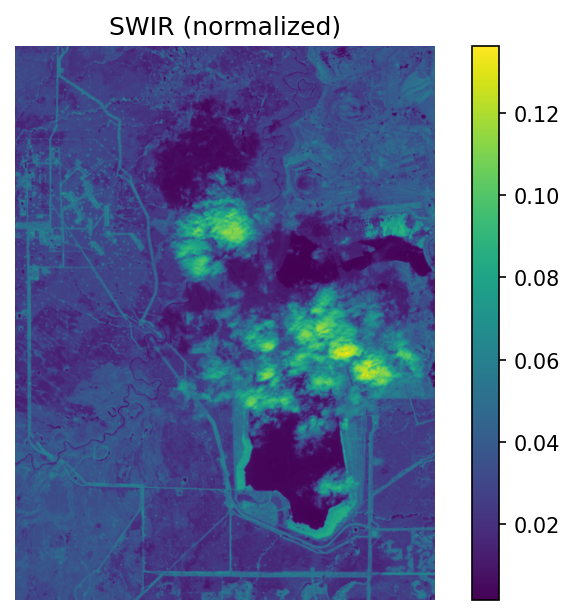

In [13]:
swir = rasterio.open(base_path.parent.joinpath("B11.tif")).read(1)
swir = swir / max

plt.imshow(swir)
plt.colorbar()
plt.axis("off")
plt.title("SWIR (normalized)")

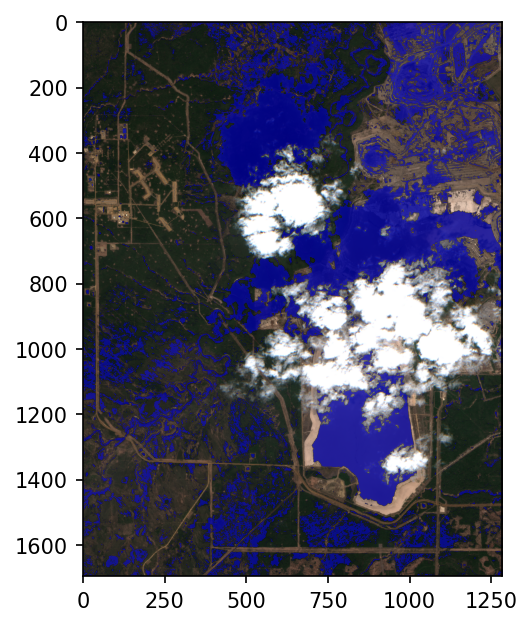

In [22]:
# See where the NIR is below the pit filled value

# Comes from Jeff's code
boundary = 0.025482567
nir_threshold = nir < boundary

plt.imshow(rgb_image)
mask_image = np.zeros((*nir_threshold.shape, 4))
mask_image[..., 2] = nir_threshold
mask_image[..., 3] = nir_threshold * 0.5
plt.imshow(mask_image)

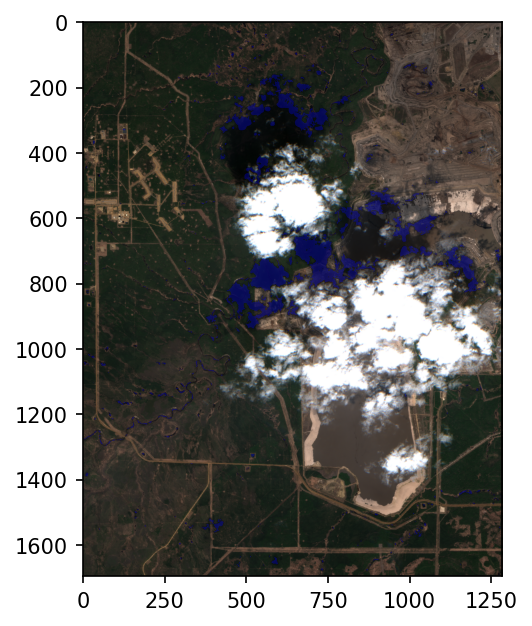

In [57]:
shadows = rasterio.open(base_path.parent.joinpath("shadow_mask.tif")).read(1)

plt.imshow(rgb_image)
mask_image = np.zeros((*shadows.shape, 4))
mask_image[..., 2] = shadows
mask_image[..., 3] = shadows * 0.3
plt.imshow(mask_image)

(-0.5, 1283.5, 1696.5, -0.5)

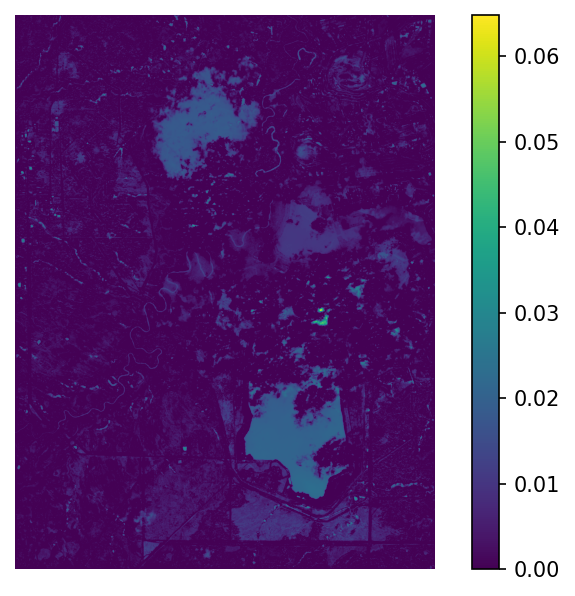

In [37]:
# NIR difference

diff = rasterio.open(base_path.joinpath("shadow_difference.tif")).read(1)

plt.imshow(diff)
plt.colorbar()
plt.axis("off")